In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import matching_catalog
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
sys.path.append('../target_selection/')
import lbg
import specz_efficiency
sys.path.append('../')
import degrade_photometry

In [2]:
data_path = '/global/cfs/cdirs/desi/users/cpayerne/data_WP221_Target_selection/'
xmm_clauds_hsc = Table.read(data_path + 'XMMLSS_11bands-SExtractor-Lephare.fits')

In [3]:
xmm_clauds_hsc_clean = xmm_clauds_hsc[xmm_clauds_hsc['MASK']==0]
mag_depth_deep = [27.1, 27, 26.5]
mag_depth_lssty4 = [25.0, 26.0, 26.0]
imaging = 'deep'
if imaging == 'lssty4':
    xmm_clauds_hsc_clean = degrade_photometry.degrade(xmm_clauds_hsc_clean, 
                                                      ['uS','g','r'], 
                                                      mag_depth_deep, 
                                                      mag_depth_lssty4, 
                                                      'lssty4')

In [4]:
def quality(tab, conv):
    mask = tab[conv['u']] > 0
    mask = tab[conv['g']] > 0
    mask = tab[conv['r']] > 0
    mask = (tab[conv['u_err']] > 0)*(tab[conv['u_err']] < 10)
    mask = tab[conv['g_err']] > 0
    mask = tab[conv['r_err']] > 0
    return mask

def XMMLSS_uS_dropout(tab, conv):
    mask = tab[conv['u']] - tab[conv['g']] > 0.3
    mask *= (0 < tab[conv['g']] - tab[conv['r']]) * (tab[conv['g']] - tab[conv['r']] < 0.8)
    mask_1 = (tab[conv['u']] - tab[conv['g']] > 2.0*(tab[conv['g']] - tab[conv['r']]) + 0.42)
    mask_2 = ((tab[conv['u']] - tab[conv['g']] > 1.6*(tab[conv['g']] - tab[conv['r']]) + 0.55))
    mask *= (mask_1 + mask_2)
    return mask

def XMMLSS_rband(tab, conv):
    mask = (tab[conv['r']] > 22.7)*(tab[conv['r']] < 24.3)
    return mask
    
def XMMLSS_uS_dropout_highz(tab, conv):
    mask = (tab[conv['u']] - tab[conv['g']] > 1)#*(tab[conv['u']] - tab[conv['g']] < 2.5)
    mask *= (0.1 < tab[conv['g']] - tab[conv['r']]) * (tab[conv['g']] - tab[conv['r']] < 1.1)
    mask *= (tab[conv['u']] - tab[conv['g']] > ((2-0.75)/0.75)*(tab[conv['g']] - tab[conv['r']]) + 0.75)
    return mask

In [5]:
conv = dict()
conv['u'] = 'uS'
conv['g'] = 'g'
conv['r'] = 'r'
conv['u_err'] = 'uS_err'
conv['g_err'] = 'g_err'
conv['r_err'] = 'r_err'
if imaging == 'lssty4':
    conv = dict()
    conv['u'] = 'uS_lssty4'
    conv['g'] = 'g_lssty4'
    conv['r'] = 'r_lssty4'
    conv['u_err'] = 'uS_lssty4_err'
    conv['g_err'] = 'g_lssty4_err'
    conv['r_err'] = 'r_lssty4_err'

In [6]:
mask_udrop = XMMLSS_uS_dropout(xmm_clauds_hsc_clean, conv) * quality(xmm_clauds_hsc_clean, conv)
mask_udrop_highz = XMMLSS_uS_dropout_highz(xmm_clauds_hsc_clean, conv) * quality(xmm_clauds_hsc_clean, conv)
mask_rband = XMMLSS_rband(xmm_clauds_hsc_clean, conv)

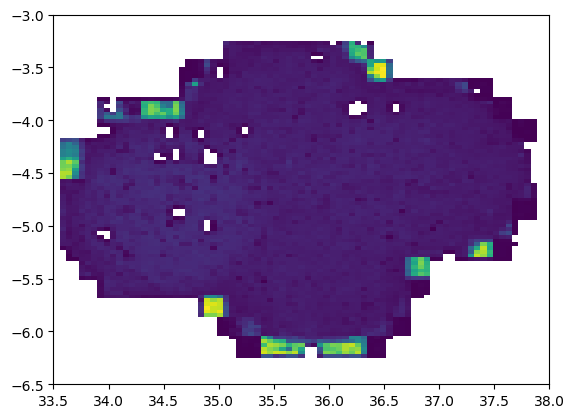

9.412543153050004


In [7]:
bins=[np.linspace(33.5, 38, 80), 
    np.linspace(-6.5, -3, 100)]
h, x, y, _=plt.hist2d(xmm_clauds_hsc_clean['RA'], xmm_clauds_hsc_clean['DEC'],
           cmin=1, bins=bins)
plt.show()
print(len(h[h>1]) * (bins[0][1] - bins[0][0]) * (bins[1][1] - bins[1][0]))

In [12]:
u_udrop = xmm_clauds_hsc_clean[mask_udrop * mask_rband][conv['u']]
g_udrop = xmm_clauds_hsc_clean[mask_udrop * mask_rband][conv['g']]
r_udrop = xmm_clauds_hsc_clean[mask_udrop * mask_rband][conv['r']]
u_udrop_highz = xmm_clauds_hsc_clean[mask_udrop_highz * mask_rband][conv['u']]
g_udrop_highz = xmm_clauds_hsc_clean[mask_udrop_highz * mask_rband][conv['g']]
r_udrop_highz = xmm_clauds_hsc_clean[mask_udrop_highz * mask_rband][conv['r']]

ucat = xmm_clauds_hsc_clean[mask_rband][conv['u']]
gcat = xmm_clauds_hsc_clean[mask_rband][conv['g']]
rcat = xmm_clauds_hsc_clean[mask_rband][conv['r']]
z = xmm_clauds_hsc_clean[mask_rband]['ZPHOT']

mask_star = (xmm_clauds_hsc_clean[mask_rband]['OBJ_TYPE']> 1.5)

In [14]:
Table_udropout = xmm_clauds_hsc_clean[mask_udrop * mask_rband]

In [18]:
Table_udropout.write(data_path + 'catalog_LBG_udropout_XMMLSS_11bands-SExtractor-Lephare.fits')

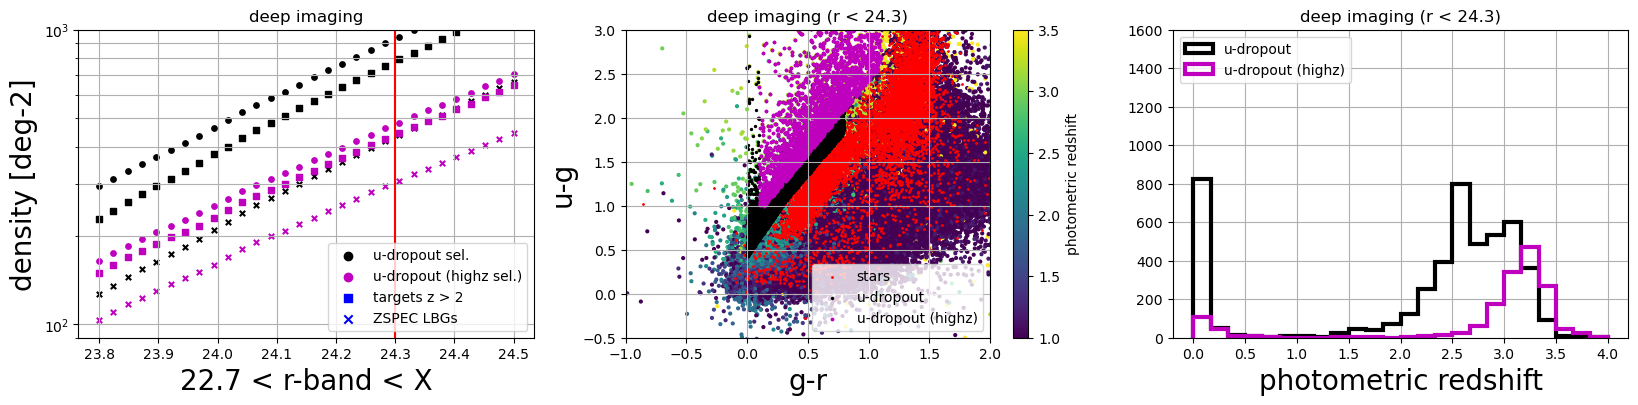

In [9]:
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.title(f'{imaging} imaging')
plt.grid(which='both')
z_bins=np.linspace(0, 4.5, 20)
z_bins_mid = np.array([(z_bins[i]+z_bins[i+1])/2 for i in range(len(z_bins)-1)])
for r in np.linspace(23.8, 24.5, 30):

    #target selection
    S = 9.4
    mask = (xmm_clauds_hsc_clean['r'] > 22.7)*(xmm_clauds_hsc_clean['r'] < r)
    z_phot_ok = xmm_clauds_hsc_clean['ZPHOT'] > 0 
    plt.scatter(r, np.sum(mask*mask_udrop)/S, color = 'k', s=15)

    z_udrop = xmm_clauds_hsc_clean['ZPHOT'][mask*mask_udrop*z_phot_ok]
    hist, bin_edges = np.histogram(z_udrop, bins=z_bins)
    hist_norm = hist/np.trapz(hist, z_bins_mid)
    mask_z = z_bins_mid>2.
    alpha_z = np.trapz(hist_norm[mask_z],z_bins_mid[mask_z],  )
    plt.scatter(r,  alpha_z * np.sum(mask*mask_udrop)/S, color = 'k', marker='s',s=15)

    alpha_z_specz = np.trapz(hist_norm[mask_z] * specz_efficiency.success_rate(z_bins_mid[mask_z], which='2h'),z_bins_mid[mask_z],  )
    plt.scatter(r,  alpha_z_specz * np.sum(mask*mask_udrop)/S, color = 'k', marker='x',s=15)

    #######################
    mask = (xmm_clauds_hsc_clean['r'] > 22.7)*(xmm_clauds_hsc_clean['r'] < r)
    z_phot_ok = xmm_clauds_hsc_clean['ZPHOT'] > 0 
    plt.scatter(r, np.sum(mask*mask_udrop_highz)/S, color = 'm', s=15)

    z_udrop_highz = xmm_clauds_hsc_clean['ZPHOT'][mask*mask_udrop_highz*z_phot_ok]
    hist, bin_edges = np.histogram(z_udrop_highz, bins=z_bins)
    hist_norm = hist/np.trapz(hist, z_bins_mid)
    mask_z = z_bins_mid>2.
    alpha_z = np.trapz(hist_norm[mask_z],z_bins_mid[mask_z],  )
    plt.scatter(r,  alpha_z * np.sum(mask*mask_udrop_highz)/S, color = 'm', marker='s',s=15)

    alpha_z_specz = np.trapz(hist_norm[mask_z] * specz_efficiency.success_rate(z_bins_mid[mask_z], which='2h'),z_bins_mid[mask_z],  )
    plt.scatter(r,  alpha_z_specz * np.sum(mask*mask_udrop_highz)/S, color = 'm', marker='x',s=15)

    



plt.xlabel('22.7 < r-band < X', fontsize=20)
plt.ylabel('density [deg-2]', fontsize=20)
plt.scatter([], [], marker='o', color='k', label = 'u-dropout sel.')
plt.scatter([], [], marker='o', color='m', label = 'u-dropout (highz sel.)')

plt.scatter([], [], marker='s', color='b', label = 'targets z > 2')
plt.scatter([], [], marker='x', color='b', label = 'ZSPEC LBGs')
plt.ylim(9e1, 1000)
plt.yscale('log')
plt.vlines(24.3, 0, 10000, color='r')
plt.legend()

plt.subplot(132)
plt.grid()
plt.title(f'{imaging} imaging (r < 24.3)')
plt.scatter(gcat[z>0]-rcat[z>0], ucat[z>0]-gcat[z>0], c = z[z>0], s=4, vmin=1, vmax=3.5, cmap='viridis')
plt.colorbar(label='photometric redshift')
plt.scatter(gcat[mask_star]-rcat[mask_star], ucat[mask_star]-gcat[mask_star], s=1, c = 'r', label = 'stars')
plt.scatter(g_udrop-r_udrop, u_udrop-g_udrop, c='k', s=2, label = 'u-dropout')
plt.scatter(g_udrop_highz-r_udrop_highz, u_udrop_highz-g_udrop_highz,c='m', s=3, label = 'u-dropout (highz)')
plt.xlim(-1, 2)
plt.ylim(-0.5, 3)
plt.legend(loc='lower right')
plt.xlabel('g-r', fontsize=20)
plt.ylabel('u-g', fontsize=20)

plt.subplot(133)
plt.title(f'{imaging} imaging (r < 24.3)')
bins=np.linspace(0, 4., 25)
n, x, _ = plt.hist(xmm_clauds_hsc_clean[mask_udrop * mask_rband]['ZPHOT'], 
                   bins=bins, color = 'k', histtype='step', linewidth=3,
                  label = 'u-dropout')
n, x, _ = plt.hist(xmm_clauds_hsc_clean[mask_udrop_highz* mask_rband ]['ZPHOT'], 
                   bins=bins, color = 'm', histtype='step', linewidth=3,
                  label = 'u-dropout (highz)')
plt.grid()
plt.ylim(0, 1600)
plt.legend(loc = 'upper left')
plt.xlabel('photometric redshift', fontsize=20)
plt.savefig(f'sel_lbg_dropout_{imaging}.png', dpi = 300, bbox_inches='tight' )

In [ ]:
plt.figure(figsize=(4,4))
plt.title(f'{imaging} imaging')
plt.grid(which='both')
for r in np.linspace(23.8, 24.5, 30):

    #target selection
    S = 9.4
    mask = (xmm_clauds_hsc_clean['r'] > 22.7)*(xmm_clauds_hsc_clean['r'] < r)
    z_phot_ok = xmm_clauds_hsc_clean['ZPHOT'] > 0 
    plt.scatter(r, np.sum(mask*mask_udrop)/S, color = 'k', s=15)
    plt.scatter(r, np.sum(mask*mask_udrop_highz)/S, color='m', s=15)

    #target selection: inside desired redshift range
    z_phot_ok = xmm_clauds_hsc_clean['ZPHOT'] > 0 
    z_udrop = xmm_clauds_hsc_clean['ZPHOT'][mask*mask_udrop*z_phot_ok]
    z_udrop_highz = xmm_clauds_hsc_clean['ZPHOT'][mask*mask_udrop_highz*z_phot_ok]
    plt.scatter(r, np.sum((z_udrop>2))/S, color = 'k', marker='s', s=20)
    plt.scatter(r, np.sum((z_udrop_highz>2))/S, color = 'm', marker='s', s=20)

    #target selection: specz efficiency
    w = specz_efficiency.success_rate(z_udrop, which='2h')
    plt.scatter(r, np.sum(w)/S, color = 'k', marker='x', s=15)

    w = specz_efficiency.success_rate(z_udrop_highz, which='2h')
    plt.scatter(r, np.sum(w)/S, color = 'm', marker='x', s=15)

plt.xlabel('22.7 < r-band < X', fontsize=20)
plt.ylabel('density [deg-2]', fontsize=20)
plt.scatter([], [], color='k', label = 'u-dropout')
plt.scatter([], [], color='m', label = 'u-dropout (highz)')
plt.ylim(2e1, 1000)
#plt.yscale('log')
plt.vlines(24.3, 0, 10000, color='r')
plt.legend()